In this notebook we implement a simple VAE with the reparameterisation trick and the fundamental trick.

In [1]:
import numpy, matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

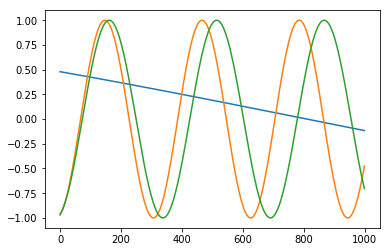

In [2]:
%matplotlib inline
N = 10000
D = 1000
xs = numpy.linspace(0, 10 * numpy.pi, D)[None, :]
dataset = numpy.sin(numpy.random.normal(0, numpy.pi, (N, 1)) + numpy.random.normal(1, 0.5, (N, 1)) * xs)
plt.plot(dataset[:3].T)

In [3]:
import torch, torch.nn as nn
def torchify(x):
    x = torch.from_numpy(x)
    if torch.cuda.is_available():
        x = x.cuda()
    return x
def numpify(x):
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.detach().numpy()
    return x

We'll start by implementing a VAE with the reparameterisation trick.

In [4]:
mseloss = nn.MSELoss()

class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, repr_size, z_draws=7, kl_weight=1):
        super().__init__()
        self.input_size = self.n = input_size
        self.repr_size = self.k = repr_size
        self.hidden_size = self.h = hidden_size
        self.kl_weight = kl_weight
        self.z_draws = z_draws
        
        self.encoder = nn.Sequential(
            nn.Linear(self.n, self.h),
            nn.Tanh(),
            nn.Linear(self.h, self.h),
            nn.Tanh(),
            nn.Linear(self.h, self.k * 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.k, self.h),
            nn.Tanh(),
            nn.Linear(self.h, self.h),
            nn.Tanh(),
            nn.Linear(self.h, self.n),
        )
    
    def forward(self, x):
        # Encode
        x = self.encoder(x)
        x = x.view(-1, 2, self.k)
        # Reparameterisation trick
        mu = x[:, 0]
        sigma = x[:, 1]
        sigma_ = sigma.mul(0.5).exp_()
        # eps is N x k x z_draws
        eps = torch.DoubleTensor(sigma_.size() + (self.z_draws,)).normal_()
        eps = torch.transpose(eps, 1, 2)
        eps = torch.autograd.Variable(eps)
        if torch.cuda.is_available():
            eps = eps.cuda()
        # x is N x z_draws x k
        x = eps.mul(sigma_[:, None, :]).add_(mu[:, None, :])
        # Decode
        x = x.view(-1, self.k)
        x = self.decoder(x)
        x = x.view(-1, self.z_draws, self.n)
        full_x = x
        x = x.mean(dim=1)
        return x, mu, sigma, full_x, eps
    
    def loss(self, recon_x, x, mu, logvar):
        BCE = mseloss(recon_x, x)
        KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
        KLD = torch.sum(KLD_element).mul_(-0.5)
        return BCE + self.kl_weight * KLD, self.kl_weight * KLD.item(), BCE.item()

In [5]:
def loss_prop_step(model, data, recon, full_recon, draws, mu, sigma, loss):
    loss.backward()

def train(model, optimiser, losses, mses, klds, loss_prop_step=loss_prop_step, n_epochs=500, do_plot=True):
    if do_plot:
        %matplotlib notebook
        fig = plt.figure(figsize=(6, 4))
        plot_loss, = plt.plot(losses, label='total')
        plot_mse, = plt.plot(mses, label='mse')
        plot_kld, = plt.plot(klds, label='kld')
        plt.gca().set_yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')

    torch_dataset = torchify(dataset)
    shuffle = numpy.arange(len(torch_dataset))
    bar = tqdm(total=n_epochs)
    for epoch in range(n_epochs):
        model.train()
        numpy.random.shuffle(shuffle)
        optimiser.zero_grad()
        recon, mu, sigma, full_recon, draws = model.forward(torch_dataset[shuffle])
        loss, kld_loss, mse_loss = model.loss(recon, torch_dataset[shuffle], mu, sigma)
        loss_prop_step(model, torch_dataset[shuffle], recon, full_recon, draws, mu, sigma, loss)
        loss_data = loss.item()
        losses.append(loss_data)
        mses.append(mse_loss)
        klds.append(kld_loss)
        optimiser.step()
        bar.update()
        bar.postfix = ' {:.6f}'.format(loss_data)
        if do_plot:
            plot_loss.set_data(range(len(losses)), numpy.array(losses))
            plot_mse.set_data(range(len(losses)), numpy.array(mses))
            plot_kld.set_data(range(len(losses)), numpy.array(klds))
            fig.gca().relim()
            fig.gca().autoscale_view()
            fig.canvas.draw()

In [6]:
def test_model(model):
    N = 5
    recon = numpify(model.forward(torchify(dataset[:10]))[0])
    plt.figure(figsize=(6, N * 1.5))
    for i in range(N):
        plt.subplot(N, 3, 1 + i * 3)
        plt.plot(dataset[i])
        plt.ylim(-1, 1)
        plt.subplot(N, 3, 2 + i * 3)
        plt.plot(recon[i])
        plt.ylim(-1, 1)
        plt.subplot(N, 3, 3 + i * 3)
        plt.scatter(range(dataset.shape[1]),
                    recon[i] - dataset[i], c=recon[i] - dataset[i], cmap='bwr',
                    s=1, vmin=-0.1, vmax=0.1)
        plt.ylim(-1, 1)

In [7]:
model = VAE(D, 50, 5, kl_weight=5e-6).double()
if torch.cuda.is_available():
    model = model.cuda()

In [8]:
losses = []
mses = []
klds = []

In [9]:
optimiser = torch.optim.Adam(model.parameters(), lr=1e-2)

In [10]:
# train(model, optimiser, losses, mses, klds)

In [11]:
# test_model(model)

Next we'll implement the fundamental trick.

In [12]:
fundamental_model = VAE(D, 50, 5, kl_weight=1e-5).double()
if torch.cuda.is_available():
    fundamental_model = fundamental_model.cuda()

In [32]:
def clear_encoder_gradients(model):
    for param in model.encoder.parameters():
        param.grad.zero_()

def fundamental_loss_prop_step(model, data, recon, full_recon, draws, mu, sigma, loss):
    # Autograd the decoder.
    loss.backward(retain_graph=True)
    # Clear gradients for the encoder.
    clear_encoder_gradients(model)
    # Differentiate the latter term with respect to all parameters in the encoder.
    mu_diff = (draws - mu[:, None, :])
    # This constructs the diagonal sigma matrix. There's no batched matrix diagonal in pytorch (yet).
    diag_sigma = torch.autograd.Variable(torch.zeros(sigma.size()[0], sigma.size()[1], sigma.size()[1]))
    diag_sigma = diag_sigma.as_strided(
        sigma.size(), [diag_sigma.stride(0), diag_sigma.size(2) + 1]).copy_(sigma).double()
    if torch.cuda.is_available():
        diag_sigma = diag_sigma.cuda()
    # (z - mu)^T S^-1 (z - mu)
    zmu = torch.matmul(torch.matmul(1 / diag_sigma[:, None, :], mu_diff.transpose(2, 1)), mu_diff)
    # Entire last term, but not differentiated
    latter = -0.5 * torch.sum(sigma, dim=1)[:, None, None] + zmu
    # Now differentiate this with respect to all dependent parameters.
    n_parameters = 
    gradients = torch.zeros(sigma.size() + (model.z_draws,))
    for l in range(sigma.size()[0]):
        for i in range(model.z_draws):
            latter_i = latter[l, 0, i]  # scalar
            latter_i.backward()
            gradients_il = [p.grad for p in model.encoder.parameters()]
            print(gradients_il.size())
            raise
            
            raise
    latter.backward()
    raise

In [33]:
f_losses = []
f_mses = []
f_klds = []
f_optimiser = torch.optim.Adam(fundamental_model.parameters(), lr=1e-2)
train(fundamental_model, f_optimiser, f_losses, f_mses, f_klds, loss_prop_step=fundamental_loss_prop_step, do_plot=False)

RuntimeError: CUDA error: out of memory

In [ ]:
torch.diag()

In [ ]:
torch.copy_()